<h1><center>Построение модели определения стоимости автомобиля</center></h1>

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Используя исторические данные (технические характеристики, комплектации и цены автомобилей), построить модель для определения цены.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель работы** – построить модель для определения рыночной стоимость автомобиля.  

**Ход работы**

1. [Подготовка данных](#Предобработка-данных)
2. [Предобработка данных](#Предобработка-данных)
3. [Исследовательский анализ](#Исследовательский-анализ)
3. [Построение моделей](#Построение-моделей)
4. [Итоговое тестирование](#Итоговое-тестирование)
5. [Вывод](#Вывод)

## Импорт модулей

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
RANDOM_STATE = 4242

## Подготовка данных

In [3]:
# загружаем данные

try:
    data = pd.read_csv(r'C:\Users\dcba5\Documents\Jupyter Data\autos.csv')
    # data = pd.read_csv(r'C:\Users\dcba5\Python_Jupyter_files\Data\autos.csv') # 
except:
    data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
initial_object_number = data.shape[0]

In [6]:
# приводим названия к нижнему регистру

data.columns = data.columns.str.lower()

In [7]:
# изменим некоторые названия

data = data.rename(columns={'datecrawled': 'crawled', 
                            'vehicletype': 'vehicle', 
                            'registrationyear': 'registration_year', 
                            'registrationmonth': 'registration_month', 
                            'fueltype': 'fuel', 
                            'datecreated': 'created_date', 
                            'numberofpictures': 'num_of_pics', 
                            'postalcode': 'postal_code', 
                            'lastseen': 'last_seen'})

## Описание данных

**Признаки :**  
  
**crawled** — дата скачивания анкеты из базы  
**vehicle** — тип автомобильного кузова  
**registration_year** — год регистрации автомобиля  
**gearbox** — тип коробки передач  
**power** — мощность (л. с.)  
**model** — модель автомобиля  
**kilometer** — пробег (км)  
**registration_month** — месяц регистрации автомобиля  
**fuel** — тип топлива  
**brand** — марка автомобиля  
**repaired** — была машина в ремонте или нет  
**created_date** — дата создания анкеты  
**num_of_pics** — количество фотографий автомобиля  
**postal_code** — почтовый индекс владельца анкеты (пользователя)  
**last_seen** — дата последней активности пользователя  
  
**Целевой признак :**  
  
**price** — цена (евро)

**Работаем с датой**

In [8]:
data['created_date'] = pd.to_datetime(data['created_date']).dt.year

In [9]:
data.loc[data['registration_year'] > data['created_date'], 'registration_year'] = data['created_date']

Сомнительно, что следующие данные влияют на цену автомобиля. Удаляем

In [10]:
data.drop('crawled', axis=1, inplace=True)
data.drop('created_date', axis=1, inplace=True)
data.drop('num_of_pics', axis=1, inplace=True)
data.drop('postal_code', axis=1, inplace=True)
data.drop('last_seen', axis=1, inplace=True)
data.drop('registration_month', axis=1, inplace=True)

Время для предобработки и исследовательского анализа.

In [11]:
data.describe()

,price,registration_year,power,kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2002.883658,110.094337,128211.172535
std,4514.158514,13.924609,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,2016.000000,20000.000000,150000.000000


In [12]:
data.head()

,price,vehicle,registration_year,gearbox,power,model,kilometer,fuel,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


## Предобработка данных

**Обработка явных дубликатов**

In [13]:
data.duplicated().sum()

45521

In [14]:
data.drop_duplicates(inplace=True)

In [15]:
data.reset_index(drop=True, inplace=True)

Явные дубликаты удалены.

**Обработка неявлных дубликатов**

In [16]:
data['vehicle'].unique().tolist()

[nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'other']

In [17]:
data['gearbox'].unique().tolist()

['manual', 'auto', nan]

In [18]:
data['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [19]:
data['fuel'].unique().tolist()

['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric']

In [20]:
data['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [21]:
data['repaired'].unique().tolist()

[nan, 'yes', 'no']

Неявных дубликатов не обнаружено.

**Обработка пропусков**

**Признаки :**  
  
**crawled** — дата скачивания анкеты из базы  
**vehicle** — тип автомобильного кузова  
**registration_year** — год регистрации автомобиля  
**gearbox** — тип коробки передач  
**power** — мощность (л. с.)  
**model** — модель автомобиля  
**kilometer** — пробег (км)  
**registration_month** — месяц регистрации автомобиля  
**fuel** — тип топлива  
**brand** — марка автомобиля  
**repaired** — была машина в ремонте или нет  
**created_date** — дата создания анкеты  
**num_of_pics** — количество фотографий автомобиля  
**postal_code** — почтовый индекс владельца анкеты (пользователя)  
**last_seen** — дата последней активности пользователя  
  
**Целевой признак :**  
  
**price** — цена (евро)

In [22]:
# получим название всех столбцов, содержащих пропуски

nan_columns = data.columns[data.isna().sum() != 0].tolist()

In [23]:
# % соотношение признаков и объектов

for col in nan_columns:
    print(f'{col} = {data[col].isna().sum() / initial_object_number:.2%}')

vehicle = 9.62%
gearbox = 4.84%
model = 5.17%
fuel = 8.64%
repaired = 18.15%


<BarContainer object of 8 artists>

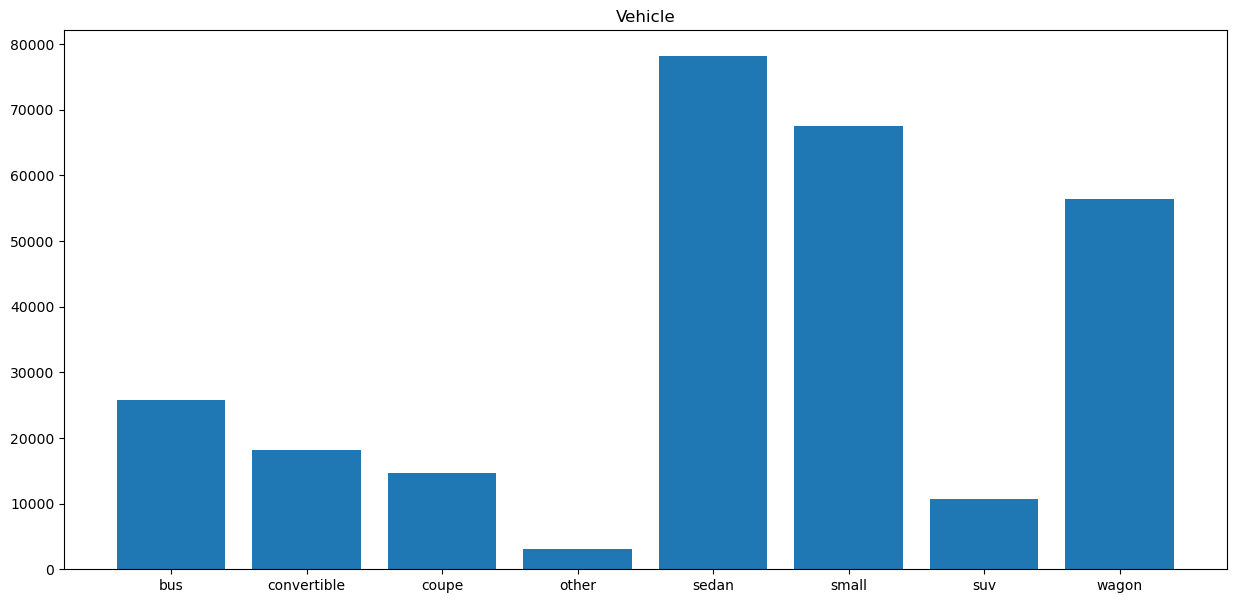

In [24]:
plt.figure(figsize=(15, 7))
plt.title('Vehicle')
plt.bar(x=data['vehicle'].groupby(data['vehicle']).count().index, 
        height=data['vehicle'].groupby(data['vehicle']).count())

Больше всего автомобилей в категориях: **small, sedan, wagon**. Заполним пропуски одним из этих значений случайным образом.

In [25]:
# общее кол-во пропусков

vehicle_null_count = data['vehicle'].isna().sum()

In [26]:
# само заполнение

data.loc[data['vehicle'].isna() == True, 'vehicle'] = np.random.choice(['small', 'sedan', 'wagon'], 
                                                                       size=vehicle_null_count)

<AxesSubplot:xlabel='vehicle', ylabel='Count'>

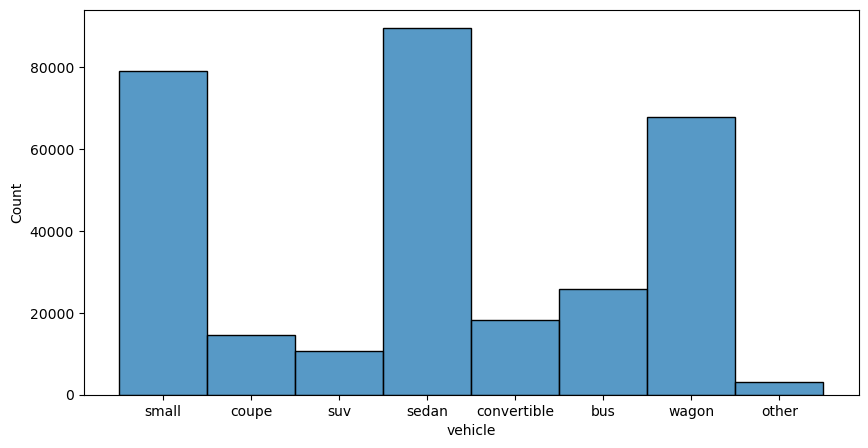

In [27]:
plt.figure(figsize=(10, 5))
sns.histplot(data['vehicle'])

In [28]:
# пропусков в этих колонках немного, заполним заглушками

data['gearbox'].fillna('unknown', inplace=True)
data['model'].fillna('unknown', inplace=True)

<BarContainer object of 7 artists>

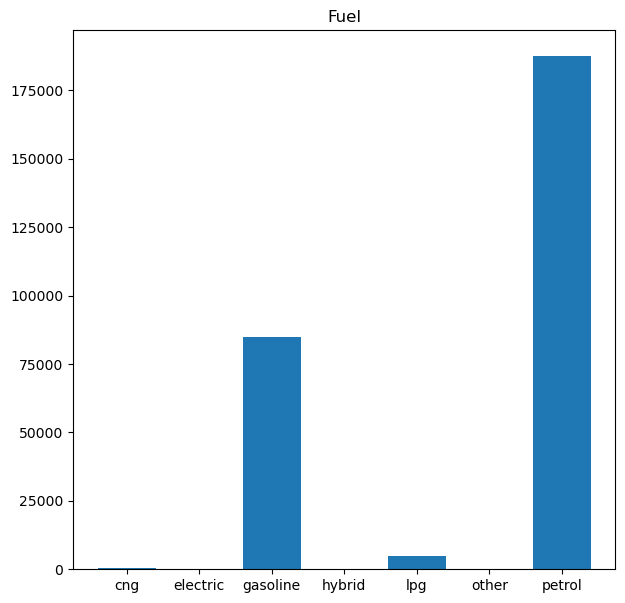

In [29]:
plt.figure(figsize=(7, 7))
plt.title('Fuel')
plt.bar(x=data['fuel'].groupby(data['fuel']).count().index, 
        height=data['fuel'].groupby(data['fuel']).count())

После небольшого углубления в суть вопроса, оказалось что слова **petrol** и **gasoline** обозначают бензин в зависимости от страны. Рискну объединить их в один класс, тем самым получив сильнейший дисбаланс классов и если модель от этого не пострадаёт возможно этот признак будет удалён. Также думаю, что будет целесообразно объединить **lpg, cng, hybrid, electric и other**, поскольку машин на альтернативных видах топлива очень мало.

In [30]:
data.loc[data['fuel'] == 'gasoline', 'fuel'] = 'petrol'

In [31]:
data.loc[(data['fuel'] == 'hybrid') | \
         (data['fuel'] == 'cng') | \
         (data['fuel'] == 'electric') | \
         (data['fuel'] == 'lpg'), 'fuel'] = 'other' 

<BarContainer object of 2 artists>

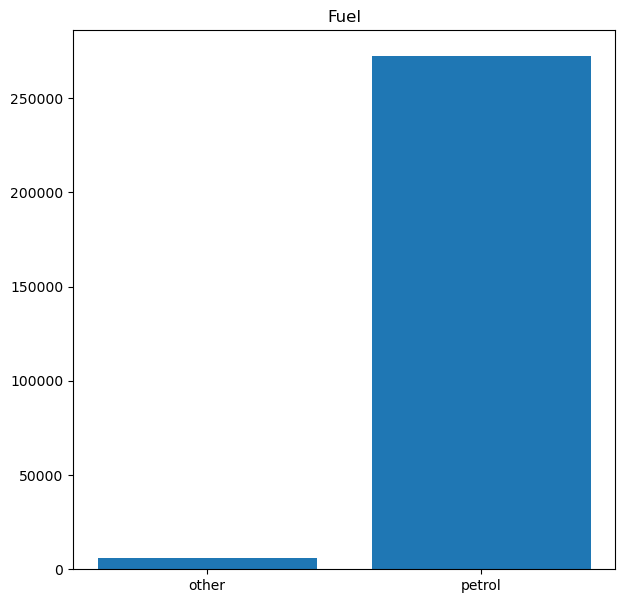

In [32]:
plt.figure(figsize=(7, 7))
plt.title('Fuel')
plt.bar(x=data['fuel'].groupby(data['fuel']).count().index, 
        height=data['fuel'].groupby(data['fuel']).count())

У нас получилось два класса машин по признаку топлива. Воспользуемся старой стратегией и заполним случайным образом.

In [33]:
# общее кол-во пропусков

fuel_null_count = data['fuel'].isna().sum()

In [34]:
# само заполнение

data.loc[data['fuel'].isna() == True, 'fuel'] = np.random.choice(['petrol', 'other'], size=fuel_null_count)

<BarContainer object of 2 artists>

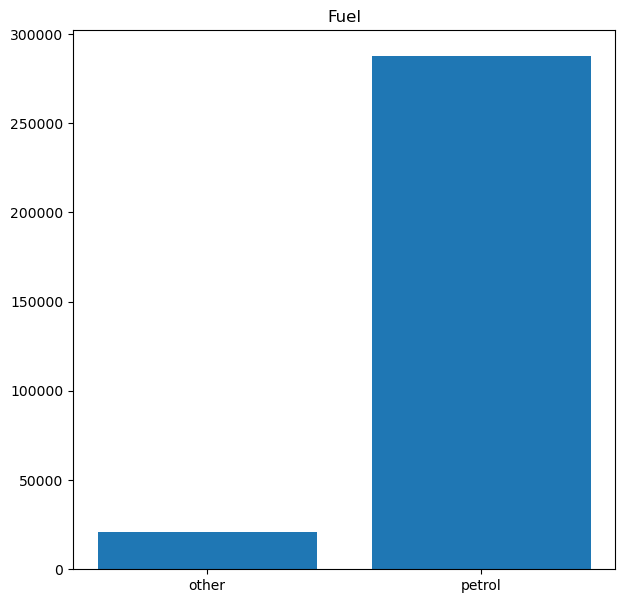

In [35]:
plt.figure(figsize=(7, 7))
plt.title('Fuel')
plt.bar(x=data['fuel'].groupby(data['fuel']).count().index, 
        height=data['fuel'].groupby(data['fuel']).count())

<BarContainer object of 2 artists>

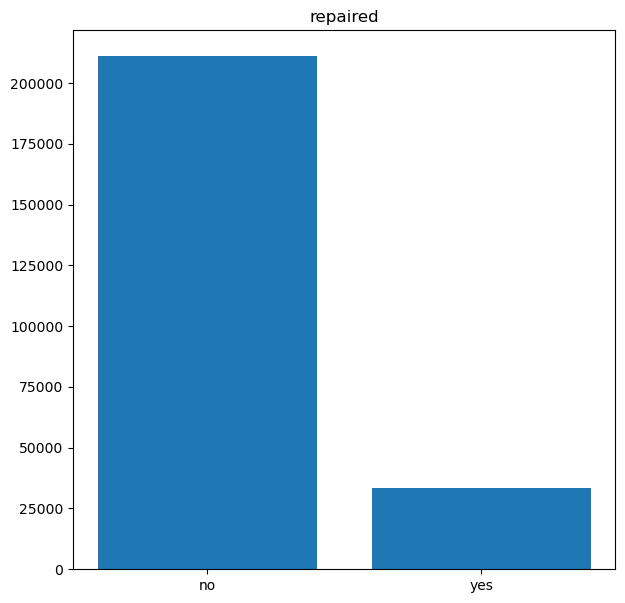

In [36]:
plt.figure(figsize=(7, 7))
plt.title('repaired')
plt.bar(x=data['repaired'].groupby(data['repaired']).count().index, 
        height=data['repaired'].groupby(data['repaired']).count())

Всемирная паутина подсказывает, что техническое обслуживание лучше проходить каждые 15-20к км пробега (вероятно на этих значениях систематически происходят поломки). Возьмём за основу данные значения и пометим все пропущенные значения основываясь на пробеге автомобиля.

In [37]:
data.loc[(data['kilometer'] >= 20000) & (data['repaired'].isna() == True), 'repaired'] = 'yes'
data.loc[(data['kilometer'] <= 20000) & (data['repaired'].isna() == True), 'repaired'] = 'no'

<BarContainer object of 2 artists>

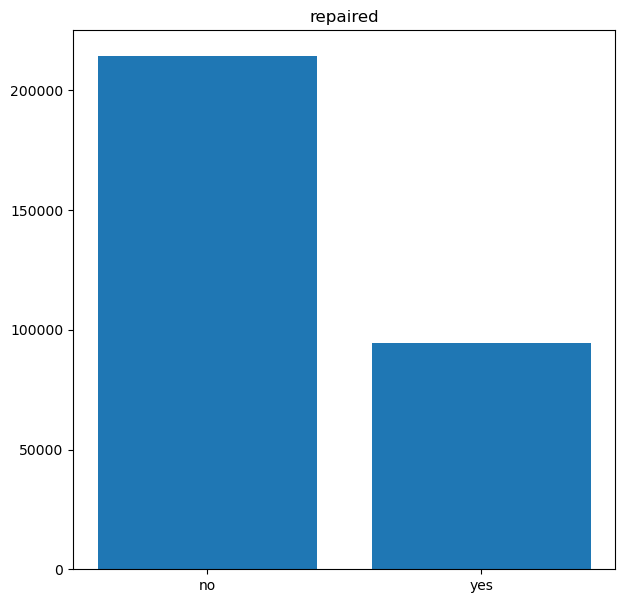

In [38]:
plt.figure(figsize=(7, 7))
plt.title('repaired')
plt.bar(x=data['repaired'].groupby(data['repaired']).count().index, 
        height=data['repaired'].groupby(data['repaired']).count())

## Исследовательский анализ

In [39]:
def eda_plots(columns, kind='box', n_plots=2, figure_size=(9, 9)):
    '''
    Функция получает на вход признаки определённого типа данных
    и желаемый тип графика
    
    Функция строит графики переданного ей типа для всех признаков
    '''
    i = 1
    
    if kind == 'box':
        plt.figure(figsize=figure_size)
        for col in columns:
            plt.subplot(n_plots, n_plots, i)
            plt.title(col)
            plt.xticks(rotation=90)
            sns.boxplot(data=data[col])
            i += 1
            
    elif kind == 'hist':
        plt.figure(figsize=figure_size)
        for col in columns:
            plt.subplot(n_plots, 1, i)
            plt.title(col)
            plt.xticks(rotation=90)
            sns.histplot(data=data[col])
            i += 1

In [40]:
cat_features = data.select_dtypes(include=object).columns
num_features = data.select_dtypes(include=np.int64).columns

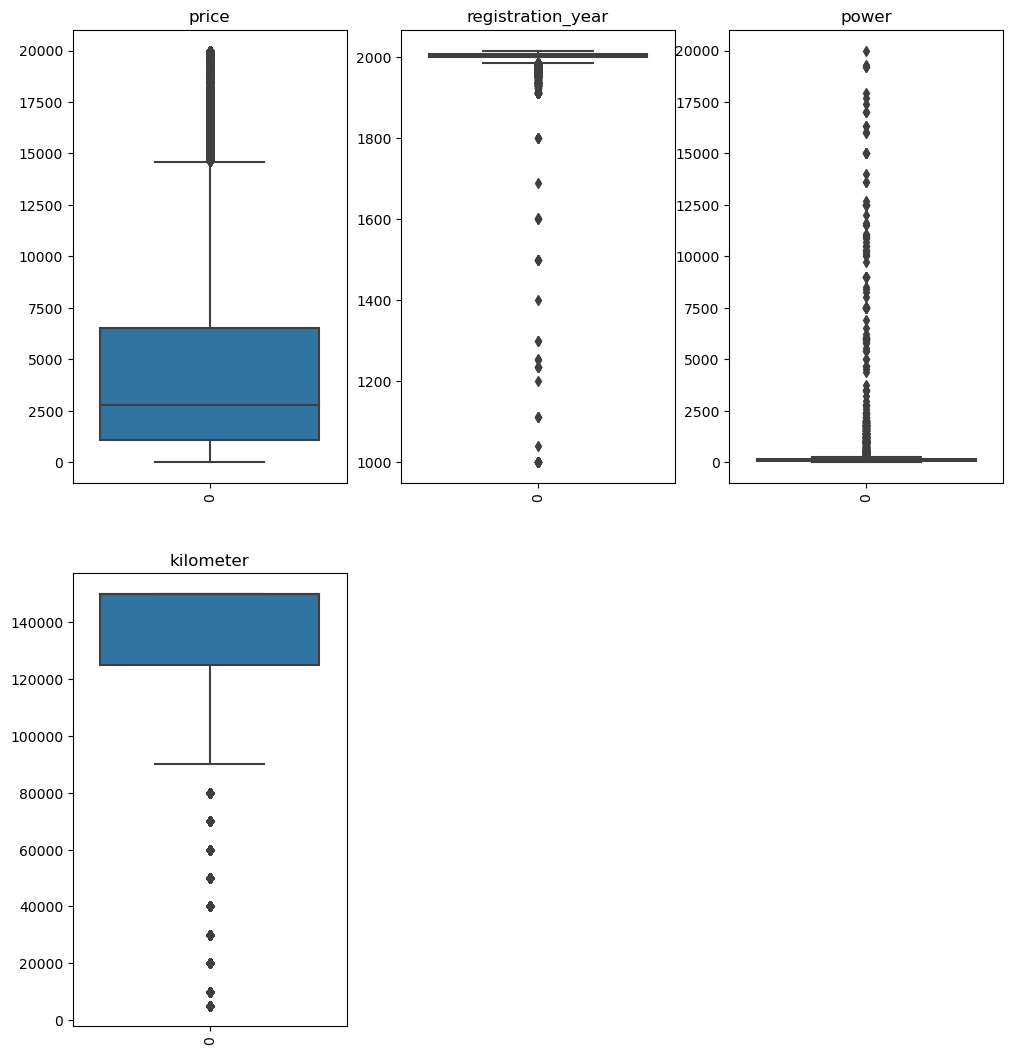

In [41]:
eda_plots(
    num_features, 
    n_plots=3, 
    figure_size=(12, 20)
)

Удаляем выбросы в годах регистрации

In [42]:
(data['registration_year'] > 2023).sum(), (data['registration_year'] < 1985).sum()

(0, 5186)

In [43]:
data = data.drop(data[(data['registration_year'] > 2023) | (data['registration_year'] < 1985)].index, axis=0)

Работаем с ценой. Воспользовался интернетом для ознакомления с ценами, выбрал пол в 250 евро.

In [44]:
data.loc[data['price'] < 250, 'price'] = 250

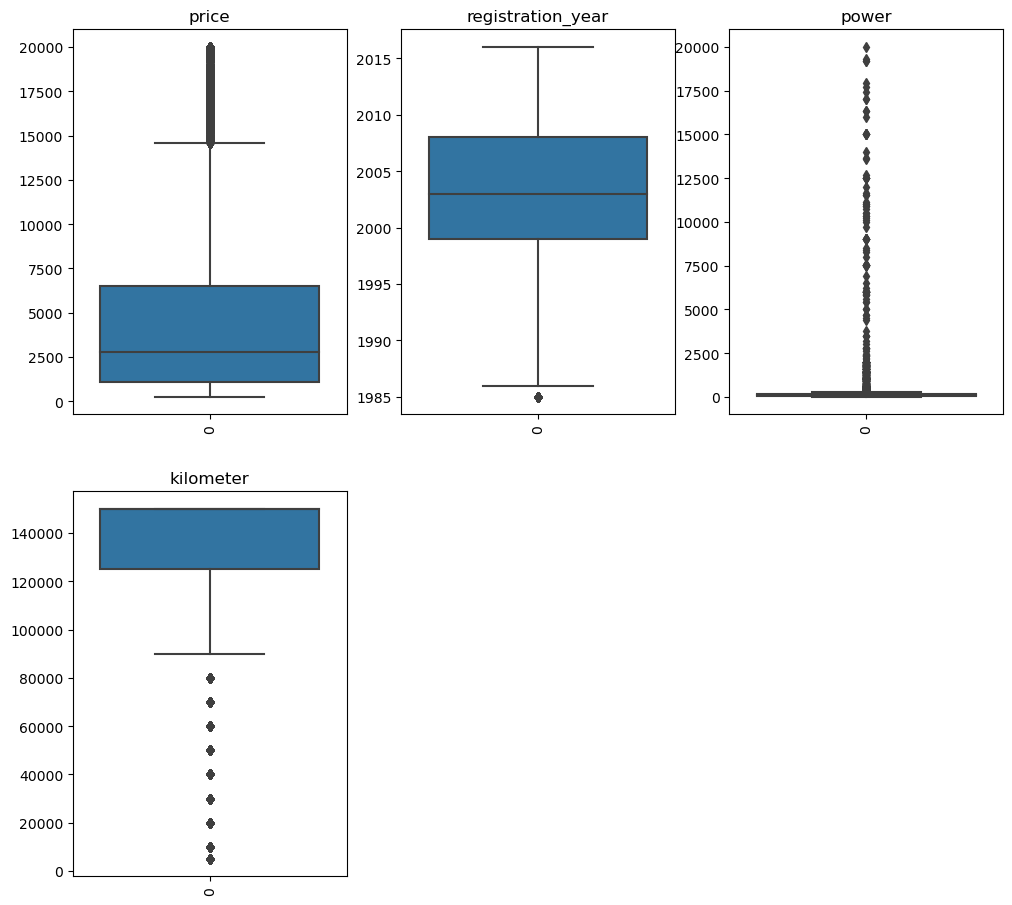

In [45]:
eda_plots(
    num_features, 
    n_plots=3, 
    figure_size=(12, 17)
)

Рассмотрим подробнее колонку с мощностью

<AxesSubplot:xlabel='power', ylabel='Count'>

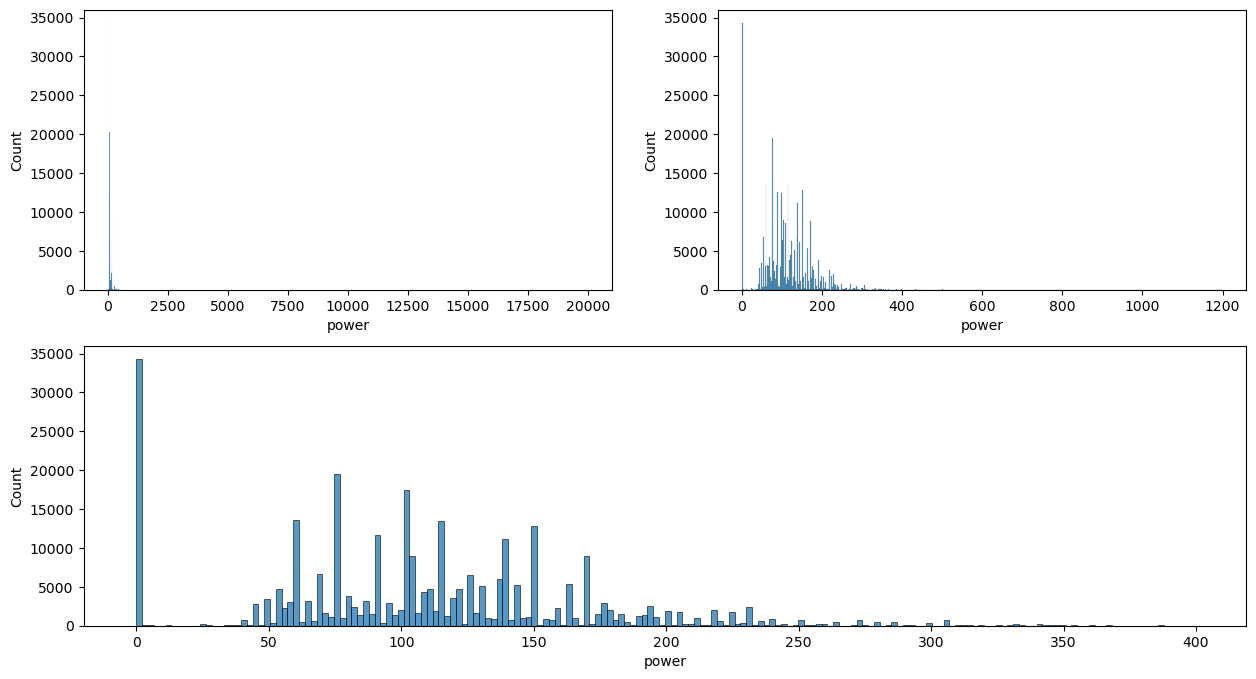

In [46]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
sns.histplot(data.loc[:, 'power'])

plt.subplot(2, 2, 2)
sns.histplot(data.loc[data['power'] < 1200, 'power'])

plt.subplot(2, 1, 2)
sns.histplot(data.loc[data['power'] < 400, 'power'])

Основная масса находится в районе от 20 до 350 л.с. Значения вплоть до 20000 - это серьёзные выбросы (воспользовался интернетом, который подсказал, что самые быстрые спорткары имеют мощность около 1200 л.с., а тягачи обходятся мощностью 500 - 1200 и только такие мощные машины как поезда способны похвастаться мощностью в 20000 л.с.). Так же большое кол-во объектов имеют нулевые значения.

In [47]:
data.query('power >= 500')['power'].count(), data.query('power <= 1')['power'].count()

(469, 34282)

Чтобы не терять объекты с нулевыми значениями, заполним эти ячейки медианой.

In [48]:
data.loc[data['power'] == 0, 'power'] = data['power'].median()

Выбросы с правой стороны гистограммы удалим в виду их немногочисленности.

In [49]:
data = data.drop(data[(data['power'] >= 350)].index, axis=0)

In [50]:
data.loc[data['power'] < 80, 'power'] = 80

<AxesSubplot:xlabel='power', ylabel='Count'>

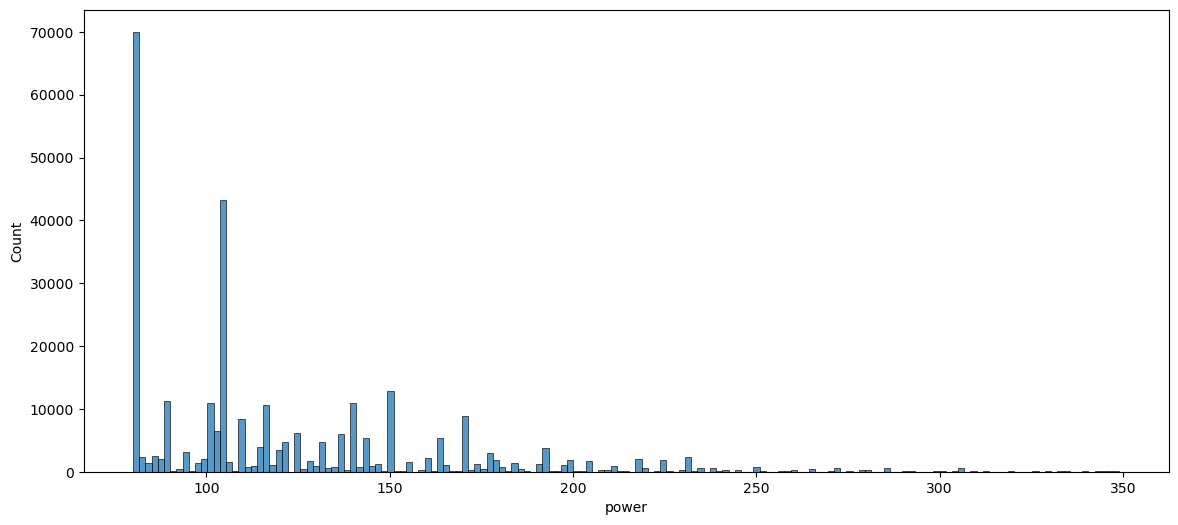

In [51]:
plt.figure(figsize=(14, 6))
sns.histplot(data['power'])

In [52]:
(data['kilometer'] <= 20000).sum()

9720

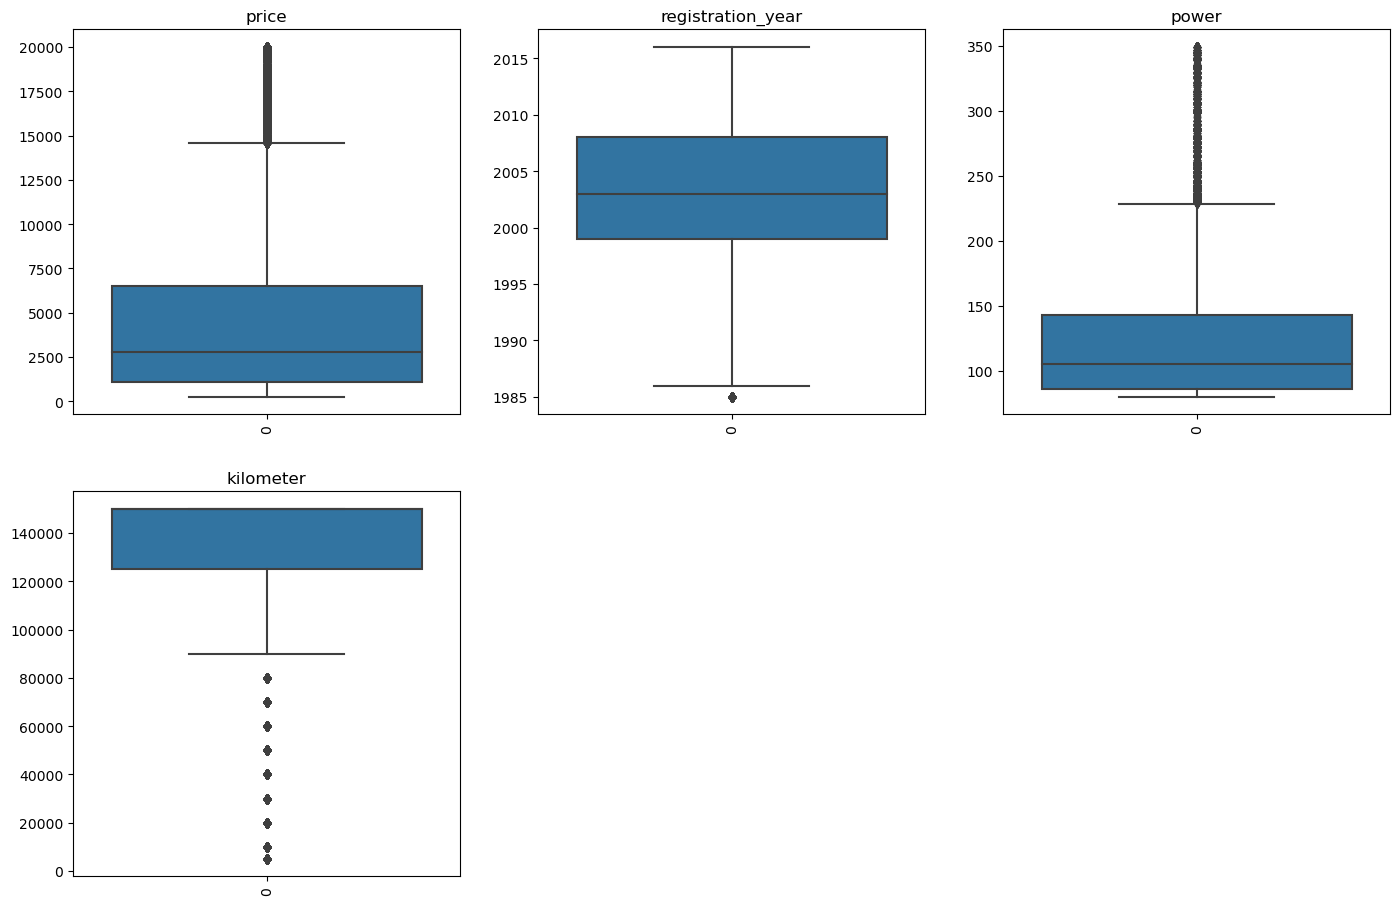

In [53]:
eda_plots(
    num_features, 
    n_plots=3, 
    figure_size=(17, 17)
)

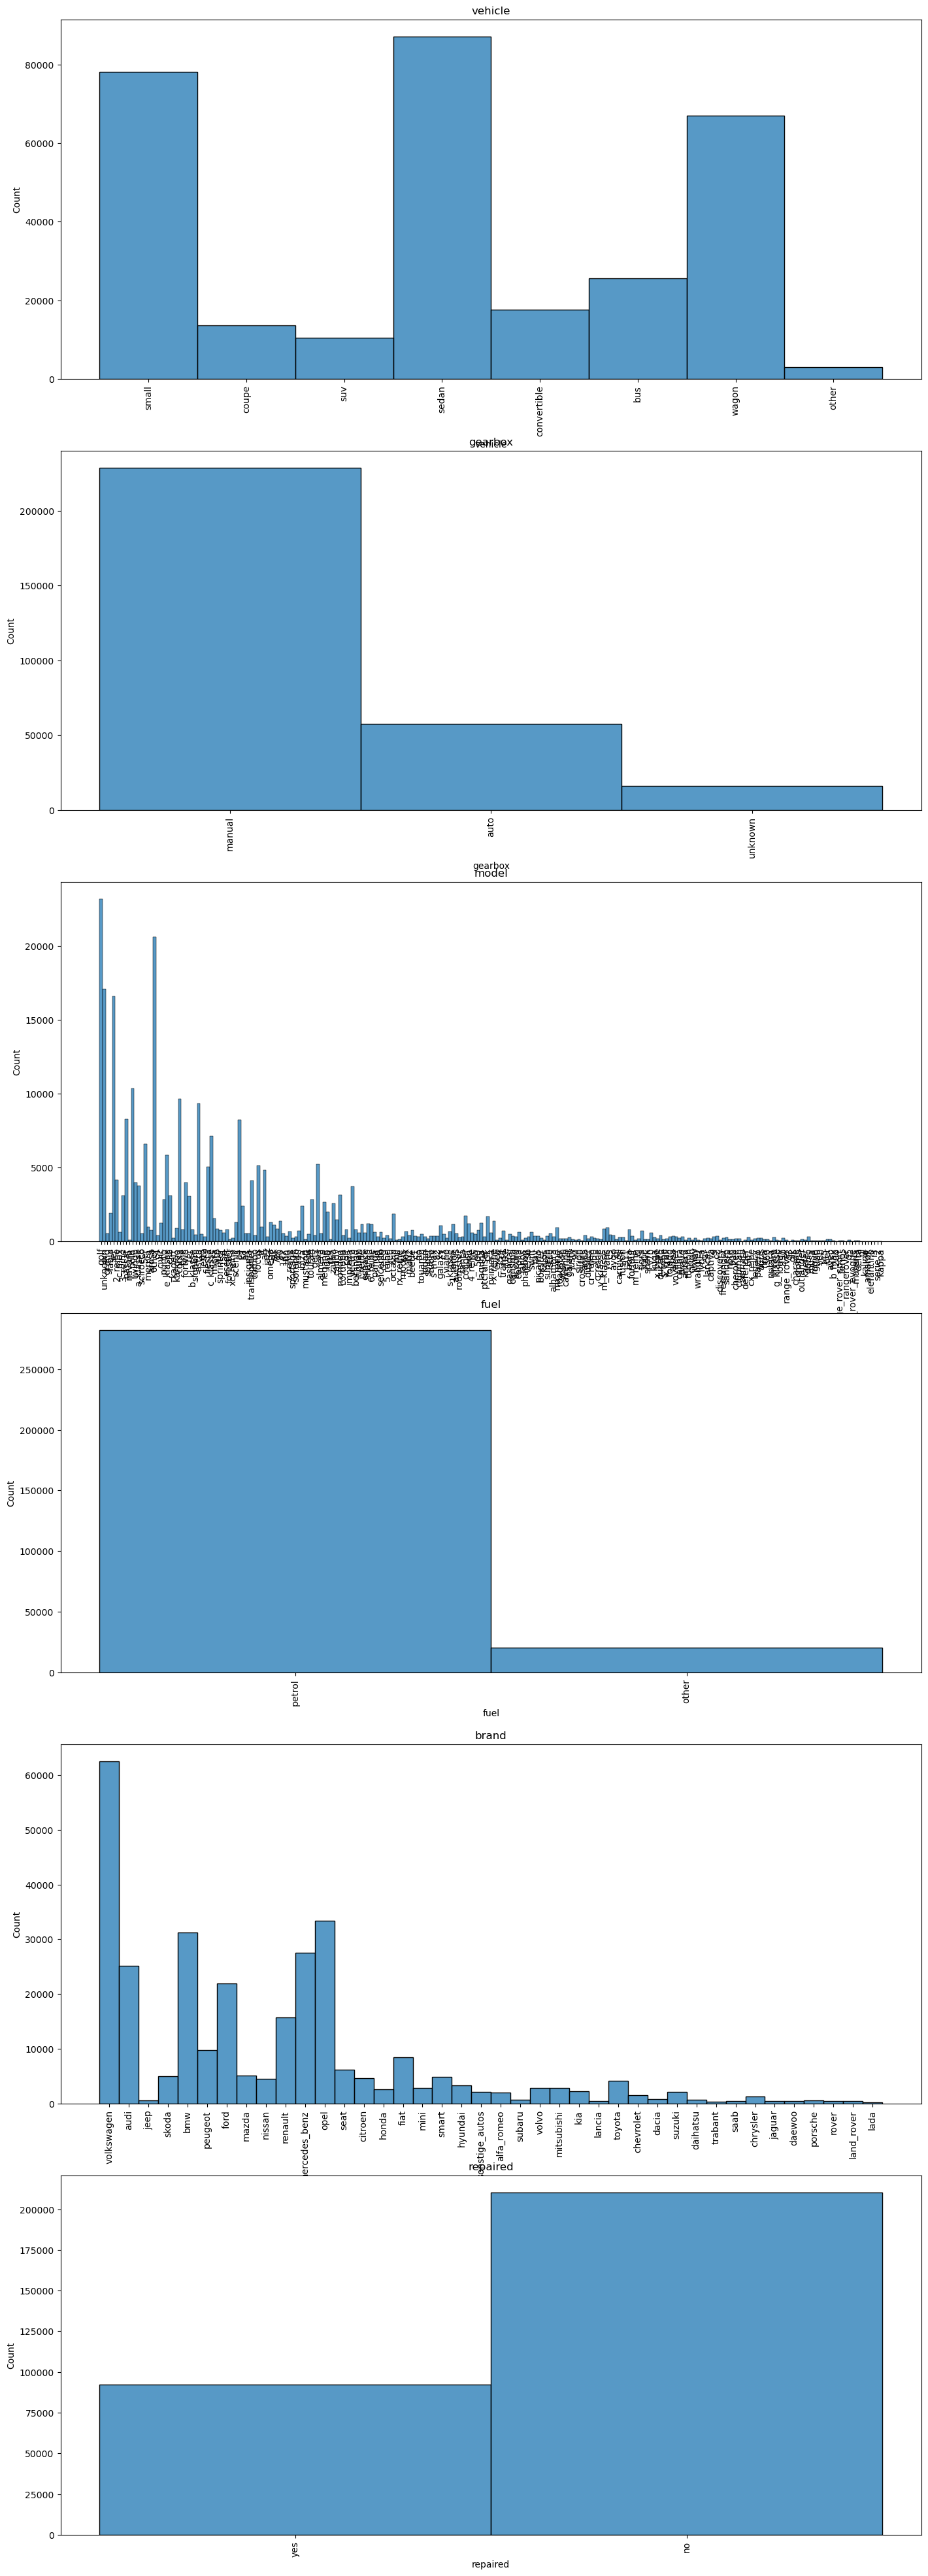

In [54]:
eda_plots(
    columns=cat_features, 
    kind='hist', 
    n_plots=len(cat_features), 
    figure_size=(17, 50)
)

In [55]:
data.describe()

,price,registration_year,power,kilometer
count,302529.000000,302529.000000,302529.000000,302529.000000
mean,4457.367264,2003.578011,122.250283,127775.800006
std,4516.600021,6.411551,44.889432,37954.973670
min,250.000000,1985.000000,80.000000,5000.000000
25%,1099.000000,1999.000000,86.000000,125000.000000
50%,2777.000000,2003.000000,105.000000,150000.000000
75%,6490.000000,2008.000000,143.000000,150000.000000
max,20000.000000,2016.000000,349.000000,150000.000000


In [56]:
len(data) / initial_object_number

0.8537118088771873

## Построение моделей

<font size="4">**Подготовка к обучению**</font>

In [57]:
data.reset_index(drop=True, inplace=True)

In [58]:
# разделяем датасет

x = data.drop('price', axis=1)
y = data['price']

In [59]:
# формируем подвыборки

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)

**Проведём кодирование категориальных данных**

In [60]:
cat_features_finished = x.select_dtypes(include=object).columns

In [61]:
# создание энкодера и фит на категориальных признаках

encoder = OneHotEncoder(sparse=False, drop='first')
encoder.fit(x_train[cat_features_finished])

OneHotEncoder(drop='first', sparse=False)

In [62]:
# промежуточный датафрейм с закодированными значениями (train)

intermediate_train = pd.DataFrame(encoder.transform(x_train[cat_features_finished]), 
                                  columns=encoder.get_feature_names_out())

In [63]:
# промежуточный датафрейм с закодированными значениями (test)

intermediate_test = pd.DataFrame(encoder.transform(x_test[cat_features_finished]), 
                                 columns=encoder.get_feature_names_out())

In [64]:
# сборка финальной версии (train)

x_train = x_train \
    .drop(cat_features_finished, axis=1) \
    .merge(intermediate_train, on=x_train.index)

In [65]:
# сборка финальной версии (test)

x_test = x_test \
    .drop(cat_features_finished, axis=1) \
    .merge(intermediate_test, on=x_test.index)

<font size="4">**Обучение моделей**</font>

Для обучения я выбрал четрые модели из которых две классические - линейная регрессия и решающее дерево, и два бустинга из библиотек LightGBM и CatBoost.

**Линейная регрессия**

In [66]:
linreg = LinearRegression()

In [67]:
params = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

In [68]:
linreg_grid = GridSearchCV(linreg, 
                           param_grid=params, 
                           n_jobs=-1, 
                           scoring='neg_root_mean_squared_error', 
                           cv=3)

In [69]:
linreg_grid.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='neg_root_mean_squared_error')

In [71]:
-1 * linreg_grid.best_score_

2738.5995466990626

In [72]:
linreg_grid_results = pd.DataFrame(linreg_grid.cv_results_)[['mean_fit_time', 'mean_score_time', 'rank_test_score']]

In [73]:
linreg_fit = linreg_grid_results.loc[linreg_grid_results['rank_test_score'] == 1, 'mean_fit_time']
linreg_pred = linreg_grid_results.loc[linreg_grid_results['rank_test_score'] == 1, 'mean_score_time']

**Дерево решений**

In [74]:
tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [75]:
params = {
    'max_depth': range(10, 21, 5),
    'min_samples_split': range(2, 4),
    'min_samples_leaf': range(1, 5),
}

In [76]:
tree_grid = GridSearchCV(tree, 
                         param_grid=params, 
                         n_jobs=-1, 
                         scoring='neg_root_mean_squared_error', 
                         cv=3)

In [77]:
tree_grid.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=4242),
             n_jobs=-1,
             param_grid={'max_depth': range(10, 21, 5),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 4)},
             scoring='neg_root_mean_squared_error')

In [78]:
-1 * tree_grid.best_score_

2047.1681637709135

In [79]:
tree_grid_results = pd.DataFrame(tree_grid.cv_results_)[['mean_fit_time', 'mean_score_time', 'rank_test_score']]

In [80]:
tree_fit = tree_grid_results.loc[tree_grid_results['rank_test_score'] == 1, 'mean_fit_time']
tree_pred = tree_grid_results.loc[tree_grid_results['rank_test_score'] == 1, 'mean_score_time']

**Бустинг Light GBM**

In [81]:
lgbm = LGBMRegressor(random_state=RANDOM_STATE)

In [82]:
params = {
    'n_estimators': [1000, 2000,  500],
    'reg_lambda': np.arange(0.1, 0.3, 0.1),
}

In [83]:
lgbm_grid = GridSearchCV(lgbm, 
                         param_grid=params, 
                         n_jobs=-1, 
                         scoring='neg_root_mean_squared_error',
                         error_score='raise',
                         cv=3)

In [84]:
lgbm_grid.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise',
             estimator=LGBMRegressor(random_state=4242), n_jobs=-1,
             param_grid={'n_estimators': [1000, 2000, 500],
                         'reg_lambda': array([0.1, 0.2])},
             scoring='neg_root_mean_squared_error')

In [85]:
-1 * lgbm_grid.best_score_

1747.0719766317486

In [86]:
lgbm_grid_results = pd.DataFrame(lgbm_grid.cv_results_)[['mean_fit_time', 'mean_score_time', 'rank_test_score']]

In [87]:
lgbm_fit = lgbm_grid_results.loc[lgbm_grid_results['rank_test_score'] == 1, 'mean_fit_time']
lgbm_pred = lgbm_grid_results.loc[lgbm_grid_results['rank_test_score'] == 1, 'mean_score_time']

**Бустинг CatBoost**

In [88]:
catboost = CatBoostRegressor(thread_count=-1,
                             random_state=RANDOM_STATE,
                             learning_rate=0.1,
                             verbose=False)

In [89]:
params = {
    'n_estimators': range(1000, 2000, 500),
    'max_depth': range(1, 10, 4)
}

In [90]:
cat_grid = GridSearchCV(catboost, 
                        param_grid=params, 
                        n_jobs=-1,
                        scoring='neg_root_mean_squared_error',
                        error_score='raise',
                        cv=3)

In [91]:
cat_grid.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise',
             estimator=<catboost.core.CatBoostRegressor object at 0x00000184C66EF700>,
             n_jobs=-1,
             param_grid={'max_depth': range(1, 10, 4),
                         'n_estimators': range(1000, 2000, 500)},
             scoring='neg_root_mean_squared_error')

**Wall time**: 4min 44s

In [92]:
-1 * cat_grid.best_score_

1733.9835464319149

In [93]:
catboost_results = pd.DataFrame(cat_grid.cv_results_)[['mean_fit_time', 'mean_score_time', 'rank_test_score']]

In [97]:
cat_fit = catboost_results.loc[catboost_results['rank_test_score'] == 1, 'mean_fit_time']
cat_pred = catboost_results.loc[catboost_results['rank_test_score'] == 1, 'mean_score_time']

<font size="4">**Ключевые показатели работы моделей**</font>

In [98]:
print(f'Linear regression fit time: {linreg_fit.values[0]:.2f}, CatBoost predict time: {linreg_pred.values[0]:.2f}')
print(f'Tree fit time: {tree_fit.values[0]:.2f}, Tree predict time: {tree_pred.values[0]:.2f}')
print(f'LGBM fit time: {lgbm_fit.values[0]:.2f}, LGBM predict time: {lgbm_pred.values[0]:.2f}')
print(f'CatBoost fit time: {cat_fit.values[0]:.2f}, CatBoost predict time: {cat_pred.values[0]:.2f}\n')

print(f'Linear regression best score: {-1 * linreg_grid.best_score_:.2f}')
print(f'Tree best score: {-1 * tree_grid.best_score_:.2f}')
print(f'LGBM best score: {-1 * lgbm_grid.best_score_:.2f}')
print(f'CatBoost best score: {-1 * cat_grid.best_score_:.2f}')

Linear regression fit time: 22.50, CatBoost predict time: 0.60
Tree fit time: 10.90, Tree predict time: 0.30
LGBM fit time: 24.87, LGBM predict time: 10.82
CatBoost fit time: 70.79, CatBoost predict time: 0.22

Linear regression best score: 2738.60
Tree best score: 2047.17
LGBM best score: 1747.07
CatBoost best score: 1733.98


## Итоговое тестирование

ТЗ заказчика гласит, что нужно выбрать модель **RMSE**-метрика которой будет не больше 2500 евро. Для выполнения задания было проанализировано 4 модели: 2 из которых классические и 2 - бустинги. 3 модели справились с заданием и показали хороший результат **RMSE**. Однако немаловажной характеристикой является время работы. Самая быстрая модель (считая суммарное время обучения и предсказания) - **решающее дерево** (best time = 11.3 ms). Самая точная модель - градиентный бустинг из библиотеке **CatBoost** (best RMSE = 1733), однако время обучения у неё наибольшее. И наконец оптимальный вариант по результату и суммарному времени - **LGBM** (best RMSE = 1747, best time = 35.69 ms). 

In [102]:
# итоговый тест метрики RMSE на тестовой выборке

mean_squared_error(lgbm_grid.predict(x_test), y_test) ** 0.5

1698.165728394625

## Вывод

Для решения поставленной задачи была выполнена предобработка данных, исследовательский анализ и обучение различных моделей в кол-ве: 4 шт. Из классических моделей неплохо показало себя дерево решений, однако в ходе данной работы была выбрана наилучшая модель по скорости работы и точности получаемых значений - **LightGBM regressor**.